In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
from google.colab import files
uploaded = files.upload()

Saving house.csv to house (1).csv


In [0]:
df = pd.read_csv('house.csv')

# Data set preparation

In [0]:
df.head()

,id,date,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Filling the missing data

In [0]:
df.fillna(value=df.mean(), inplace=True)

Date to number of days conversion in a given period of time 

In [0]:
from datetime import date

def date2day(current_date, d_reference):

  d_reference = date(int(d_reference[:4]), int(d_reference[4:6]), int(d_reference[6:]))
  current_date = date(int(current_date[:4]), int(current_date[4:6]), int(current_date[6:]))
  delta = current_date - d_reference

  return delta.days

date2day_vect = np.vectorize(date2day)

absolute_day_number = date2day_vect(current_date=df['date'].str.slice(stop=8), d_reference=df['date'].str.slice(stop=8).min())
df['date'] = absolute_day_number
df.rename(columns={"date": "day_numb"}, inplace=True)

Removing 'id' column 

In [0]:
df.drop(columns=['id'], inplace=True)

In [0]:
df.head()

,day_numb,price,price_bin,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,164,221900.0,0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,221,538000.0,0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,299,180000.0,0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,221,604000.0,0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,292,510000.0,0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


**Data Exploration**

Is the data balanced?

In [0]:
labels = ['False', 'True']

In [0]:
values = [df['price_bin'].value_counts()[0], df['price_bin'].value_counts()[1]]

In [0]:
df['price_bin'].value_counts()

0    20148
1     1465
Name: price_bin, dtype: int64

Text(0.5, 0, 'Is it grater than 1 mln?')

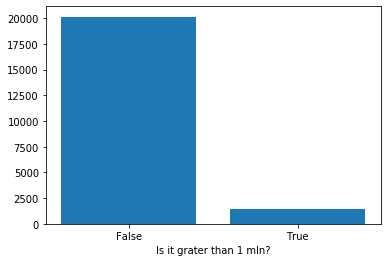

In [0]:
plt.bar(labels, values)
plt.xlabel('Is it grater than 1 mln?')

I see that I have unbalanced data

I decided to use the up-sample the minority class

In [0]:
from sklearn.utils import resample

In [0]:
# Separate majority and minority classes
df_majority = df[df['price_bin']== 0]
df_minority = df[df['price_bin']== 1]
 

In [0]:
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=123) # reproducible results

In [0]:
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

In [0]:
df_upsampled['price_bin'].value_counts()

1    20148
0    20148
Name: price_bin, dtype: int64

In [0]:
y = df_upsampled['price_bin'].values
X = df_upsampled.drop(columns=['price', 'price_bin', 'zipcode'])
feature_names = df_upsampled.columns
X = X.values

Density curves for each class based on each feature


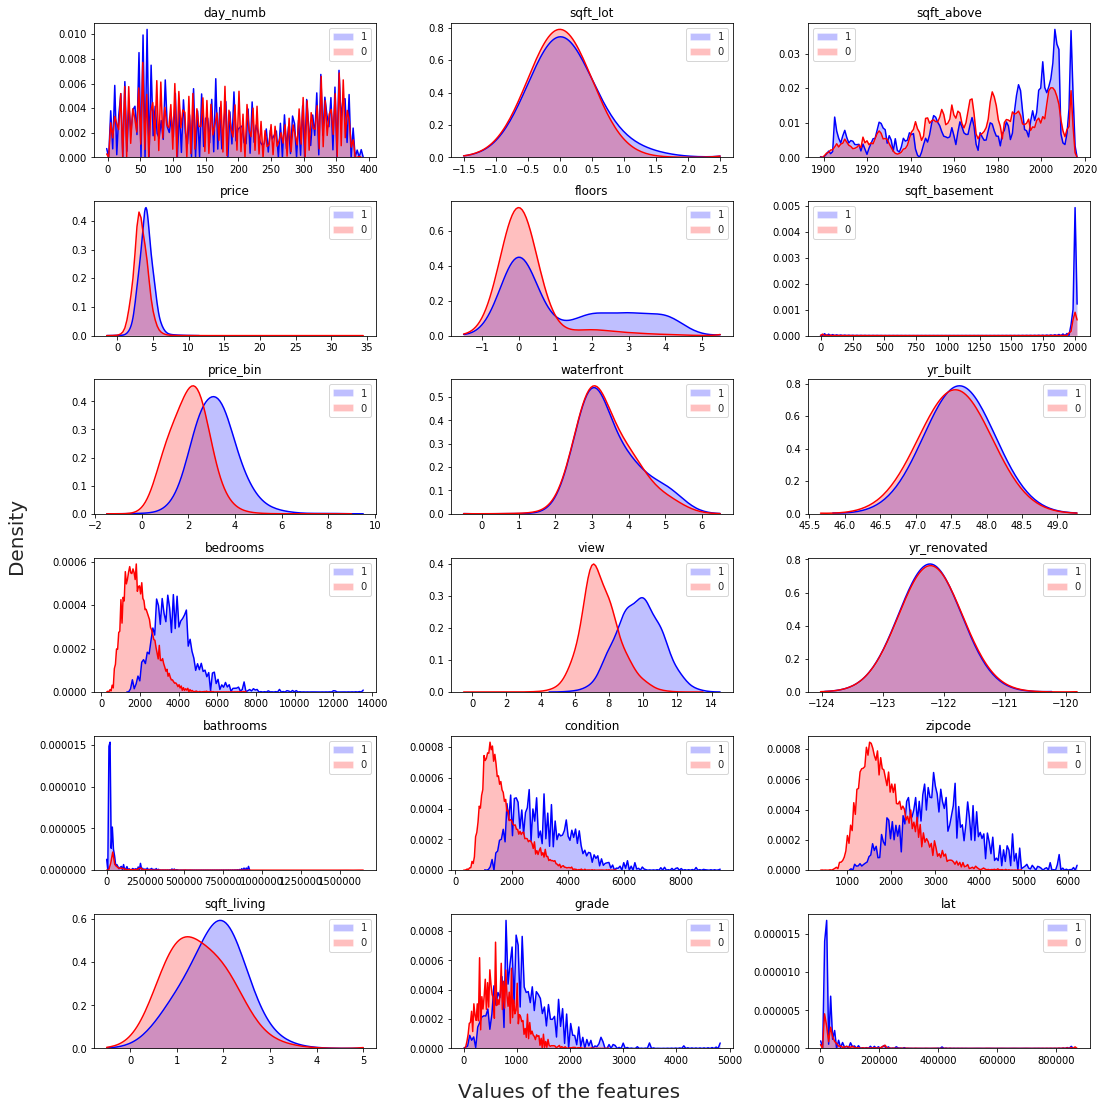

In [0]:
import seaborn as sns

f, axes = plt.subplots(6, 3, figsize=(15,15))
sns.set_style('whitegrid')

feature_number = 0 
for j in range(3):
  for i in range(6):
    sns.kdeplot(X[:,feature_number][y == 1], bw=0.5, shade=True, color = 'blue', ax=axes[i,j])
    sns.kdeplot(X[:,feature_number][y == 0], bw=0.5, shade=True, color = 'red', ax=axes[i,j])
    axes[i,j].set_title(feature_names[feature_number])
    axes[i,j].legend(['1', '0'])
    feature_number += 1


f.text(0.5, -0.02, 'Values of the features', ha='center', fontsize = 20)
f.text(-0.02, 0.5, 'Density', va='center', rotation='vertical', fontsize = 20)

f.tight_layout()


Price value over time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


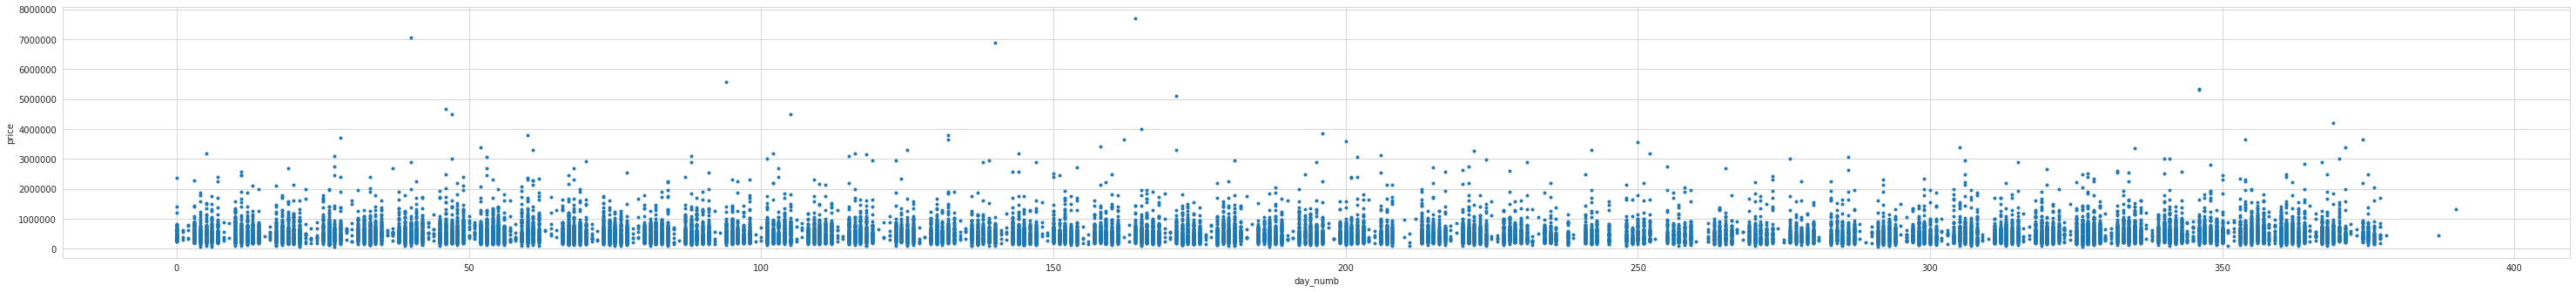

In [0]:
fig = plt.figure(figsize=(50,5))
axes = fig.add_axes([0,0,0.8,0.8])
axes.plot(df['day_numb'],df['price'],'.')
axes.set_ylabel('price')
axes.set_xlabel('day_numb')
fig.tight_layout()


> I decided to make a simplifying assumption without treating this data as time series because the time interval is relatively small.



Plotting correlation matrix

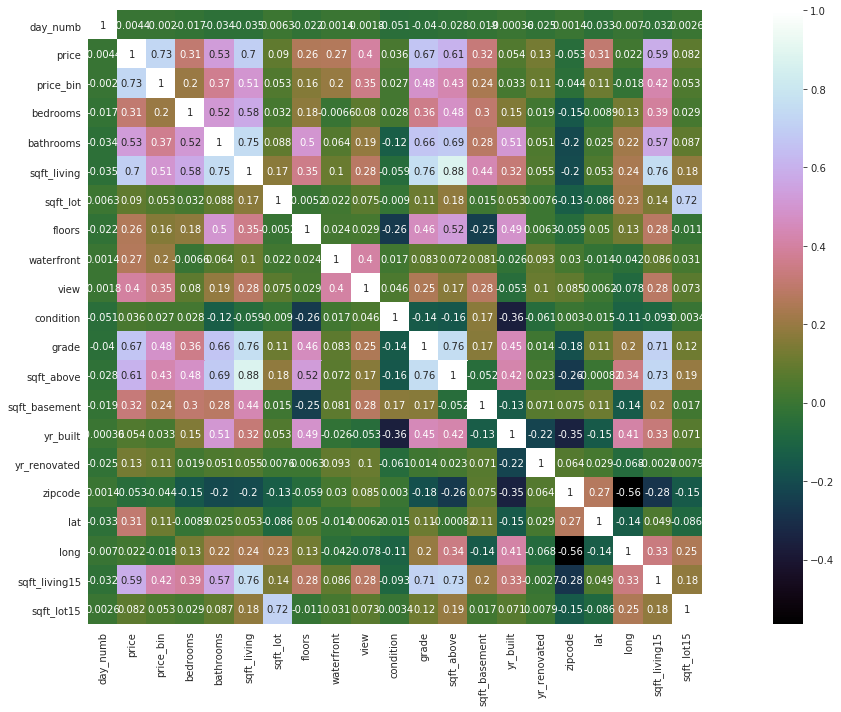

In [0]:
corr_mat=df.corr(method='pearson')
plt.figure(figsize=(20,10))
sns.heatmap(corr_mat,vmax=1,square=True,annot=True,cmap='cubehelix')
plt.tight_layout()

Zipcode converted to one hot encode

In [0]:
zipcodes = df_upsampled['zipcode'].unique()

zipcode_to_int = dict((z, i) for i, z in enumerate(zipcodes))
int_to_zipcode = dict((i, z) for i, z in enumerate(zipcodes))

integer_encoded = [zipcode_to_int[zipcode] for zipcode in df_upsampled['zipcode']]

onehot_encoded = list()

for value in integer_encoded:
	codes = [0 for _ in range(len(zipcodes))]
	codes[value] = 1
	onehot_encoded.append(codes)

zipcodes_in_onehot = onehot_encoded
X = np.append(X, zipcodes_in_onehot, axis=1)

Splitting the data to the training and testing sets

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Standrization

In [0]:
from sklearn.preprocessing import StandardScaler 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Prediction of  **'price_bin'** value

## Choosing the best model using K-fold cross-validation

Logistic Regression

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']

lr_clf = LogisticRegression()

scores = cross_validate(lr_clf, X_train, y_train, scoring=scoring, cv=10)

lr_scores = pd.DataFrame.from_dict(scores).mean()

In [0]:
lr_scores

fit_time                1.016565
score_time              0.015103
test_accuracy           0.954430
test_precision_macro    0.954628
test_recall_macro       0.954446
test_f1_weighted        0.954425
test_roc_auc            0.989325
dtype: float64

Decision tree

In [0]:
from sklearn import tree

dt_clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth=23)

scores = cross_validate(dt_clf, X_train, y_train, scoring=scoring, cv=10)

dt_clf_scores = pd.DataFrame.from_dict(scores).mean()
dt_clf_scores

fit_time                0.331255
score_time              0.011435
test_accuracy           0.988367
test_precision_macro    0.988624
test_recall_macro       0.988385
test_f1_weighted        0.988366
test_roc_auc            0.988405
dtype: float64

Support-vector machine

In [0]:
from sklearn.svm import SVC

In [0]:
svc = SVC(kernel='rbf')

scores = cross_validate(svc, X_train, y_train, scoring=scoring, cv=10)

svc_scores = pd.DataFrame.from_dict(scores).mean()
svc_scores

fit_time                45.126263
score_time               4.286594
test_accuracy            0.964450
test_precision_macro     0.964938
test_recall_macro        0.964474
test_f1_weighted         0.964441
test_roc_auc             0.991636
dtype: float64

Linear Discriminant Analysis

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

scores = cross_validate(lda, X_train, y_train, scoring=scoring, cv=10)

lda_scores = pd.DataFrame.from_dict(scores).mean()
lda_scores

fit_time                0.604647
score_time              0.013955
test_accuracy           0.937120
test_precision_macro    0.937546
test_recall_macro       0.937143
test_f1_weighted        0.937105
test_roc_auc            0.985272
dtype: float64


Quadratic Discriminant Analysis

In [0]:
qda = QuadraticDiscriminantAnalysis()

scores = cross_validate(qda, X_train, y_train, scoring=scoring, cv=10)

qda_scores = pd.DataFrame.from_dict(scores).mean()

In [0]:
qda_scores

fit_time                0.304538
score_time              0.033315
test_accuracy           0.662613
test_precision_macro    0.786278
test_recall_macro       0.663101
test_f1_weighted        0.621511
test_roc_auc            0.890331
dtype: float64


Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=0)

scores = cross_validate(rfc, X_train, y_train, scoring=scoring, cv=5)

rfc_scores = pd.DataFrame.from_dict(scores).mean()
rfc_scores

fit_time                7.520112
score_time              0.485227
test_accuracy           0.991252
test_precision_macro    0.991386
test_recall_macro       0.991265
test_f1_weighted        0.991251
test_roc_auc            0.999993
dtype: float64

Final models comparison

In [0]:
global_scores = pd.concat([dt_clf_scores, lr_scores, svc_scores, lda_scores, qda_scores, rfc_scores], axis=1) 
global_scores.columns = ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest']
global_scores

,Logistic Regression,Decision Tree,Support Vector Machine,Linear Discriminant Analysis,Quadratic Discriminant Analysis,Random Forest
fit_time,0.331255,1.016565,45.126263,0.604647,0.304538,7.520112
score_time,0.011435,0.015103,4.286594,0.013955,0.033315,0.485227
test_accuracy,0.988367,0.954430,0.964450,0.937120,0.662613,0.991252
test_precision_macro,0.988624,0.954628,0.964938,0.937546,0.786278,0.991386
test_recall_macro,0.988385,0.954446,0.964474,0.937143,0.663101,0.991265
test_f1_weighted,0.988366,0.954425,0.964441,0.937105,0.621511,0.991251
test_roc_auc,0.988405,0.989325,0.991636,0.985272,0.890331,0.999993




> The best results were obtained by a random forest classifier, despite the fact that compared to other models, it was trained for a relatively long time, but time is within the acceptable range.



Checking the repeatability of the results of the best model of each validation

In [0]:
pd.DataFrame.from_dict(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,test_f1_weighted,test_roc_auc
0,7.361924,0.618902,0.990074,0.990220,0.990088,0.990074,0.999977
1,7.799948,0.448727,0.989918,0.990101,0.989935,0.989917,0.999999
2,7.483330,0.455141,0.992865,0.992956,0.992875,0.992865,0.999991
3,7.442889,0.447707,0.991314,0.991450,0.991326,0.991313,1.000000
4,7.512471,0.455657,0.992089,0.992202,0.992100,0.992089,1.000000


## Training the best model (Random Forest Classifier) and testing it on the unseen data

In [0]:
rfc = rfc.fit(X_train, y_train)

In [0]:
y_pred = rfc.predict(X_test) 

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score

precision, recall, f1, N = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

rfc_training_scores = pd.DataFrame.from_dict(scores).mean()

data = [rfc_training_scores.values[2:], np.array([accuracy, precision, recall, f1, roc_auc])]

comparison_between_training_and_testing_scores = pd.DataFrame(data = data, index=['Training','Testing'], columns=scoring)
comparison_between_training_and_testing_scores

,accuracy,precision_macro,recall_macro,f1_weighted,roc_auc
Training,0.991252,0.991386,0.991265,0.991251,0.999993
Testing,0.994665,0.994752,0.994633,0.994664,0.994633




> Testing and training scores are very similar which means, that chosen random forest model is able to reproduce the general pattern from training data and use it well for unseen data






# Prediction of **'price'** value

In [0]:
y = df_upsampled['price'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Choosing the best model using K-fold cross-validation

Support Vector Regression

In [0]:
from sklearn.svm import SVR

svr = SVR() 

scores = cross_validate(svr, X_train, y_train, cv=5, scoring=['r2','neg_mean_absolute_error'])
scores_svr = pd.DataFrame.from_dict(scores).mean()

In [0]:
scores_svr

fit_time                           155.330255
score_time                          29.257795
test_r2                              0.000201
test_neg_mean_absolute_error   -535691.845869
dtype: float64

Logistic Reggression

In [0]:
lr = LogisticRegression(max_iter=100)

scores = cross_validate(lr, X_train, y_train, scoring=['r2','neg_mean_absolute_error'], cv=5)
scores_lr = pd.DataFrame.from_dict(scores).mean()

In [0]:
scores_lr

fit_time                           562.115125
score_time                           0.245173
test_r2                             -0.027094
test_neg_mean_absolute_error   -545013.006139
dtype: float64

Random Forest Regressor

In [0]:
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import cross_validate

rfr = RandomForestRegressor(n_estimators = 200, random_state = 0) 

In [0]:
scores = cross_validate(rfr, X_train, y_train, cv=5, scoring=['r2','neg_mean_absolute_error'])
scores_rfr = pd.DataFrame.from_dict(scores).mean()
scores_rfr

fit_time                           58.512253
score_time                          0.410245
test_r2                             0.991074
test_neg_mean_absolute_error   -30023.131748
dtype: float64

Final models comparison

In [0]:
global_scores = pd.concat([scores_svr, scores_lr, scores_rfr], axis=1) 
global_scores.columns = ['Vector Machine Regressor', 'Logistic Regression', 'Random Forest Regressor']
global_scores

,Vector Machine Regressor,Logistic Regression,Random Forest Regressor
fit_time,155.330255,562.115125,58.512253
score_time,29.257795,0.245173,0.410245
test_r2,0.000201,-0.027094,0.991074
test_neg_mean_absolute_error,-535691.845869,-545013.006139,-30023.131748


Checking the repeatability of the results of the best model of each validation

In [0]:
pd.DataFrame.from_dict(scores)

,fit_time,score_time,test_r2,test_neg_mean_absolute_error
0,58.627154,0.406622,0.990910,-30474.768169
1,59.026185,0.434976,0.990624,-29769.578772
2,58.609506,0.401904,0.991556,-29705.289541
3,58.253511,0.409030,0.991020,-30006.159938
4,58.044909,0.398693,0.991262,-30159.862321


## Training the best model (Random Forest Regressor) and testing it on the unseen data

In [0]:
rfr.fit(X_train, y_train)  

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [0]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = rfr.predict(X_test) 

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

Compering the prediction and real **price** value

In [0]:
data = [[scores_rfr['test_r2'], -scores_rfr['test_neg_mean_absolute_error']], np.array([r2, rmse])]

comparison_between_training_and_testing_scores = pd.DataFrame(data = data, index=['Validation average score','Testing score'], columns=['r2', 'rmse'])
comparison_between_training_and_testing_scores

,r2,rmse
Validation average score,0.991074,30023.131748
Testing score,0.989573,73924.382982


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  import sys


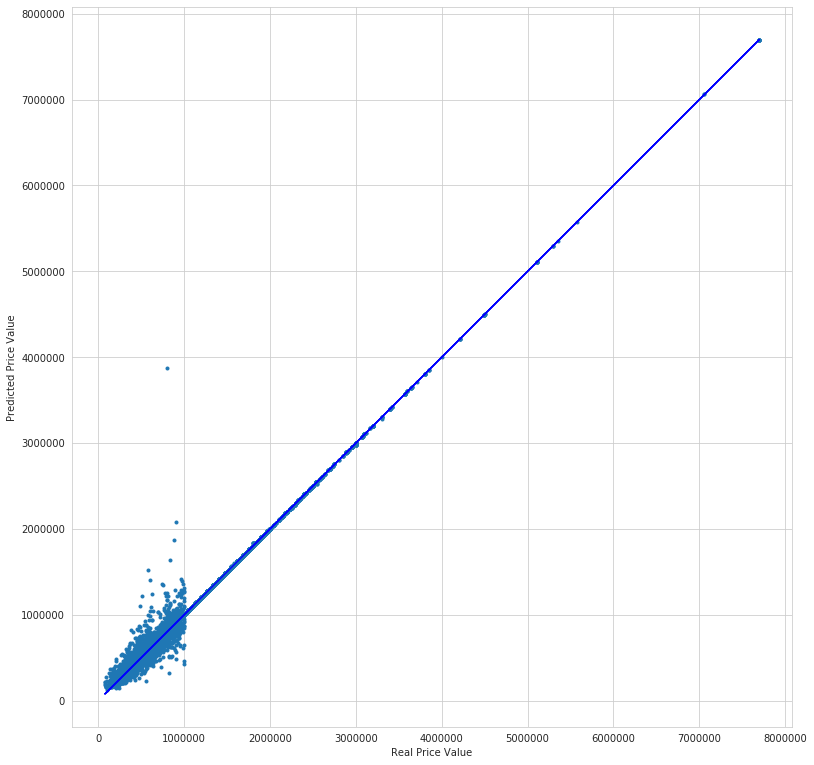

In [0]:
f_com = plt.figure(figsize=(10,10))
axes = f_com.add_axes([0,0,1,1])
axes.plot(y_test,y_pred,'.')
axes.plot(y_test,y_test,'-b')
axes.set_ylabel('Predicted Price Value')
axes.set_xlabel('Real Price Value')
f_com.tight_layout()

# Final Conclusions




*   Random Forest Classifier turned out to be the best model for binary predictability, giving a classification accuracy on test data of 0.994665. (Precision=0.994752; Recall=0.994633; F1=0.994664; ROC_AUC=0.994633)

*   While for continuous value prediction of the best proved to be Random Forest Regressor for which R squared=0.989573 and RMSE=73924.382982

*   Proposed ways to improve the solution obtained:

1.   Consideration of data as Time Series of data (Then I could use for example RNN)
2.   Trying out other available models like ANN
